# Simulating Hardy-type nonlocality through quantum circuits
- This notebook created Figures 2, 3, and 4 in the paper.
- We also want to note that this notebook was compiled when Qiskit was at version 0.23, therefore, some parts that may require modifications to ensure compatibility with the lastest versions.

# Import

In [1]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
from qiskit import IBMQ
IBMQ.load_account()
import numpy as np
import pandas as pd

In [2]:
from qiskit import Aer, BasicAer, execute, transpile, assemble
from qiskit.providers.aer import AerSimulator
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.tools.jupyter import *
from qiskit.tools.visualization import plot_histogram, circuit_drawer
import os, time
import matplotlib.pyplot as plt

# 1. Testing first set of condition
- In this circuit, a rotation gate Ry(theta) is applied to each qubit to transform them to {u,v} basis.
- The $\theta$ value used in the all circuits are 1.33 (rad)
- Two neighbouring qubits participate in a Toffoli gate to become entangled.
- There are four Toffoli gates, each controlling an individual ancilla, and they are connected through shared qubits.
# 1.1. Quantum circuit

In [3]:
#A = 0.89
pi = np.pi
theta = 1.33

In [4]:
n = 4
num_pairs = 4
q = QuantumRegister(n, 'q')
c = ClassicalRegister(n + num_pairs, 'c')
anc = QuantumRegister(num_pairs, 'anc')

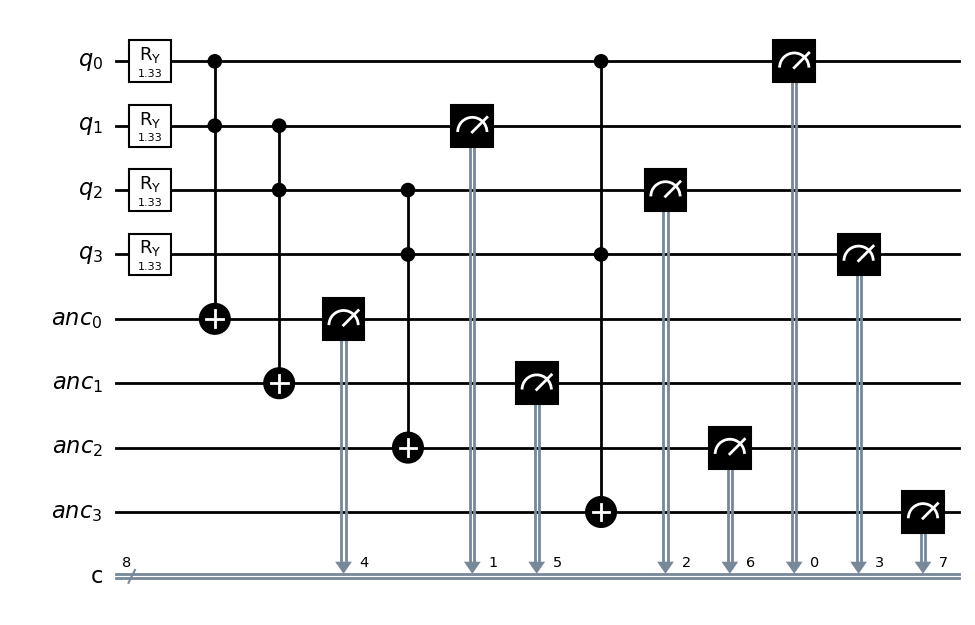

In [5]:
# 1st condition
qc1p = QuantumCircuit(q,c,anc)
qc1p.ry(theta, q)
qc1p.mct([q[0],q[1]], anc[0], mode='noancilla')
qc1p.mct([q[1],q[2]], anc[1], mode='noancilla')
qc1p.mct([q[2],q[3]], anc[2], mode='noancilla')
qc1p.mct([q[0],q[3]], anc[3], mode='noancilla')
qc1p.measure(q[0:n], c[0:n])
qc1p.measure(anc, c[n:n+num_pairs])
qc1p.draw(output='mpl', style='bw')

# 1.2. Raw data

In [6]:
backend = Aer.get_backend('qasm_simulator')
num_shots = 2048*200

job1 = execute(qc1p, backend=backend, shots=num_shots)
result1 = job1.result()
count1 = result1.get_counts()
plot_histogram(count1)

d = 0
for n in range (num_pairs):
    for k, v in list(count1.items()):
        j = 0
        for p in range (1):
            if len(k) > 0 and k[0] == '1':
                d += v
                del count1[k]
                break
            j+=1

    for k, v in list(count1.items()):
        count1[k[1:]] = count1.pop(k)
        
count1 = {state[::-1]: population for state, population in count1.items()}

# 1.3. Final result of the first set of condition
- The first set's result shows that when measuring in basis {u, v} states that have adjacent $\left|1\right\rangle$ do not appear or have zero measurement probabilities, such as $\left|1100\right\rangle$ and $\left|1111\right\rangle$.
- There are in total nine states that have zero probailities, and they are called vanished states in our paper.

In [3]:
df1 = pd.DataFrame(list(count1.items()), columns=["States", "Counts"])
df1.to_excel("cond1sim_data.xlsx", index=False)
simulation1 = pd.read_excel("cond1sim_data.xlsx", dtype={"States": str})
count1 = dict(zip(simulation1["States"], simulation1["Counts"]))

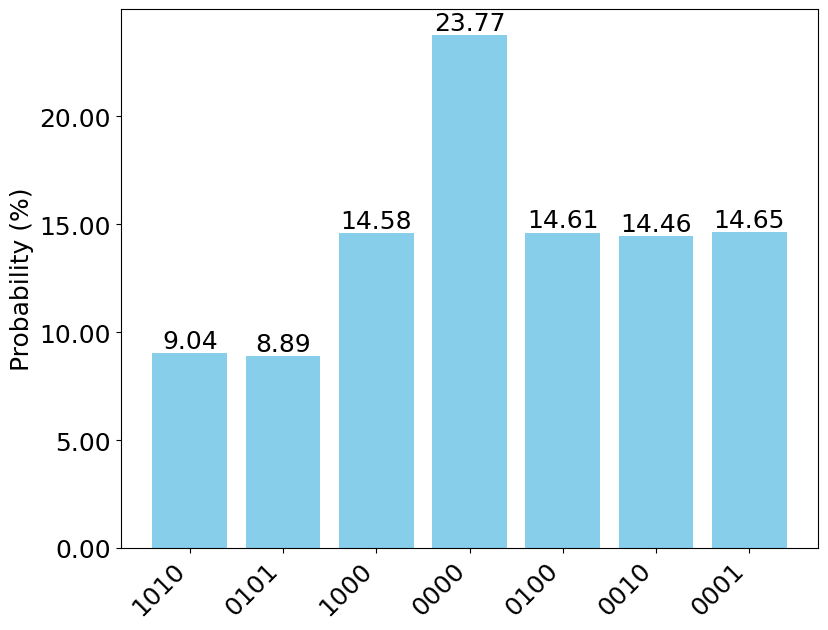

In [4]:
from matplotlib.ticker import FuncFormatter
total_count = sum(count1.values())

probabilities = {state: count / total_count for state, count in count1.items()}

states = list(probabilities.keys())  
prob_values = list(probabilities.values())

plt.figure(figsize=(9, 7))
bars = plt.bar(states, prob_values, color='skyblue')

for bar, prob in zip(bars, prob_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{prob * 100:.2f}', ha='center', va='bottom', fontsize=18)


def to_percent(y, _):
    return f'{y * 100:.2f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Probability (%)", fontsize=18)

plt.show()

# 2. Second set of condition
- In each circuit of this set, a $R_y(-\theta)$ is applied on a qubit $k^{th}$ to change it from {u, v} basis to {c, d}, while the rest are still measured in {u, v}.
- This process is repeated four times corresponding to four qubits, therefore, we have in total four circuits in this set.
- In each condition, there are several states of interest, which will be highlighted in red color.
## 2.1. Changing first qubit's basis 
### 2.1.1. Quantum circuit

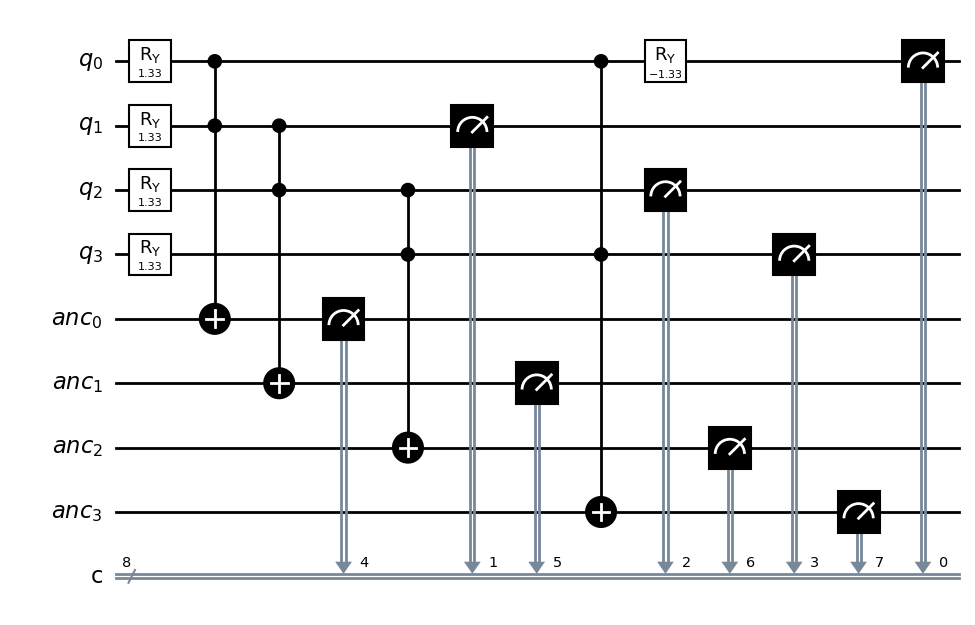

In [13]:
# 2nd condition
n = 4
num_pairs = 4
qc21p = QuantumCircuit(q,c,anc)
qc21p.ry(theta, q)
qc21p.mct([q[0],q[1]], anc[0], mode='noancilla')
qc21p.mct([q[1],q[2]], anc[1], mode='noancilla')
qc21p.mct([q[2],q[3]], anc[2], mode='noancilla')
qc21p.mct([q[0],q[3]], anc[3], mode='noancilla')
qc21p.ry(-theta, q[0])
qc21p.measure(q[0:n], c[0:n])
qc21p.measure(anc, c[n:n+num_pairs])
qc21p.draw(output='mpl', style='bw')

### 2.1.2. Raw data

In [14]:
job21 = execute(qc21p, backend=backend, shots=num_shots)
result21 = job21.result()
count21 = result21.get_counts()

d = 0
for n in range (num_pairs):
    for k, v in list(count21.items()):
        j = 0
        for p in range (1):
            if len(k) > 0 and k[0] == '1':
                d += v
                del count21[k]
                break
            j+=1

    for k, v in list(count21.items()):
        count21[k[1:]] = count21.pop(k)
        
count21 = {state[::-1]: population for state, population in count21.items()}

### 2.1.3. Final result
- In the first condition of the second set, three states of interest are $\left|1100\right\rangle, \left|1101\right\rangle$, and $\left|1001\right\rangle$.
- These states indicate that the result of a qubit only influence its paired qubit. For instnace, with $\left|1100\right\rangle$, $D_1=1 \Rightarrow U_2=1 $.
- This pattern extends to the three remaining qubits.

In [18]:
df2 = pd.DataFrame(list(count21.items()), columns=["States", "Counts"])
df2.to_excel("cond21sim_data.xlsx", index=False)
simulation21 = pd.read_excel("cond21sim_data.xlsx", dtype={"States": str})
count21 = dict(zip(simulation21["States"], simulation21["Counts"]))

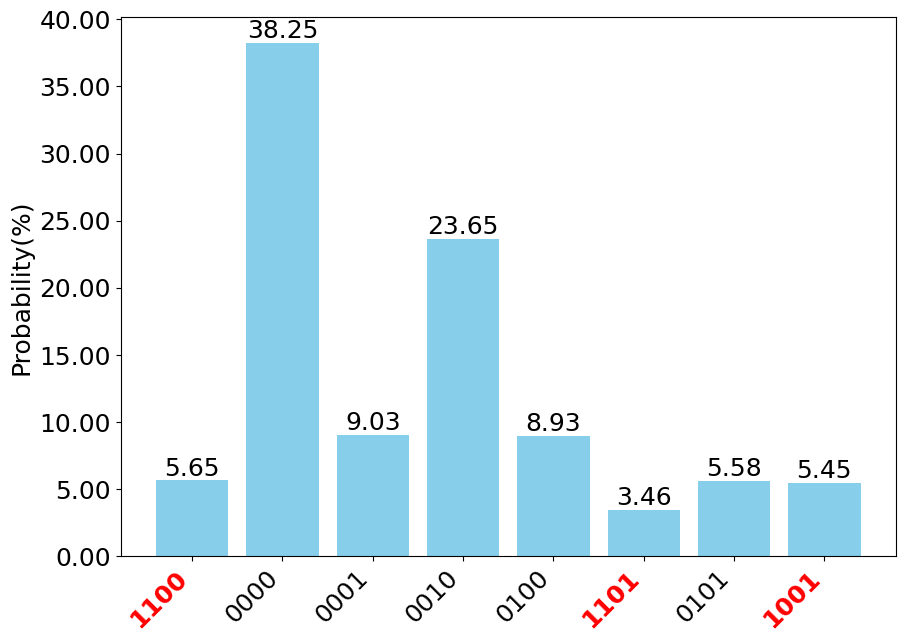

In [19]:
total_count = sum(count21.values())

probabilities = {state: count / total_count for state, count in count21.items()}

states = list(probabilities.keys())  
prob_values = list(probabilities.values())

plt.figure(figsize=(10, 7))
bars = plt.bar(states, prob_values, color='skyblue')

for bar, prob in zip(bars, prob_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
              f'{prob * 100:.2f}', ha='center', va='bottom', fontsize=18)

highlight_states = {'1001', '1101', '1100'}  
tick_labels = plt.gca().get_xticklabels()  
tick_labels_text = plt.gca().get_xticklabels() 
for label, state in zip(tick_labels_text, states):  
    if state in highlight_states:
        label.set_color('red')  
        label.set_fontweight('bold')  
        
def to_percent(y, _):
    return f'{y * 100:.2f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Probability(%)", fontsize=18)

plt.show()

## 2.2. Changing the second qubit's basis
### 2.2.1. Quantum circuit

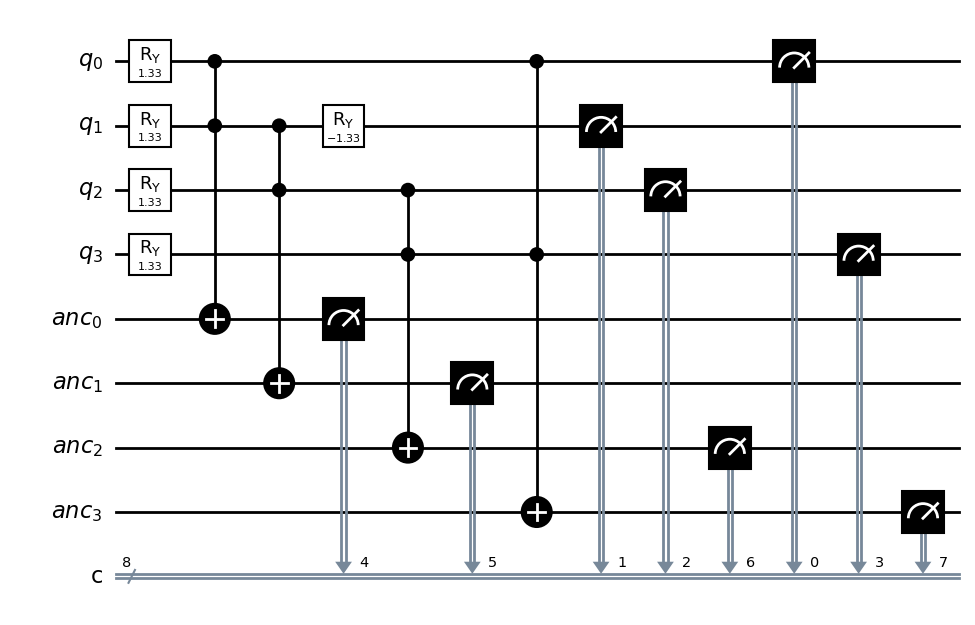

In [19]:
n = 4
num_pairs = 4
qc22p = QuantumCircuit(q,c,anc)
qc22p.ry(theta, q)
qc22p.mct([q[0],q[1]], anc[0], mode='noancilla')
qc22p.mct([q[1],q[2]], anc[1], mode='noancilla')
qc22p.mct([q[2],q[3]], anc[2], mode='noancilla')
qc22p.mct([q[0],q[3]], anc[3], mode='noancilla')
qc22p.ry(-theta, q[1])
qc22p.measure(q[0:n], c[0:n])
qc22p.measure(anc, c[n:n+num_pairs])
qc22p.draw(output='mpl', style='bw')

### 2.2.2. Raw data

In [25]:
job22 = execute(qc22p, backend=backend, shots=num_shots)
result22 = job22.result()
count22 = result22.get_counts()

d = 0
for n in range (num_pairs):
    for k, v in list(count22.items()):
        i=0
        for p in range(1):
            if len(k) > 0 and k[0] == '1':
                d = d + v
                del count22[k]
                break
            i+=1

    for k,v in list(count22.items()):
        count22[k[1:]]=count22.pop(k)

count22 = {state[::-1]: population for state, population in count22.items()}        

### 2.2.3. Final result
- In this condition, three states of interest are $\left|1100\right\rangle, \left|0110\right\rangle$, and $\left|1110\right\rangle$.

In [27]:
df3 = pd.DataFrame(list(count22.items()), columns=["States", "Counts"])
df3.to_excel("cond22sim_data.xlsx", index=False)
simulation22 = pd.read_excel("cond22sim_data.xlsx", dtype={"States": str})
count22 = dict(zip(simulation22["States"], simulation22["Counts"]))

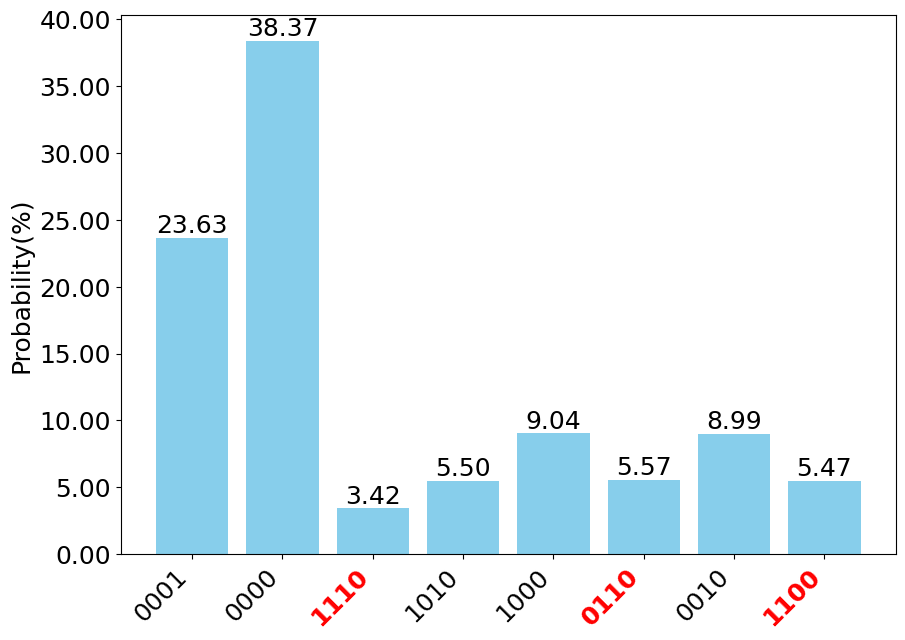

In [28]:
total_count = sum(count22.values())

probabilities = {state: count / total_count for state, count in count22.items()}

states = list(probabilities.keys())  
prob_values = list(probabilities.values())

plt.figure(figsize=(10, 7))
bars = plt.bar(states, prob_values, color='skyblue')

for bar, prob in zip(bars, prob_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{prob * 100:.2f}', ha='center', va='bottom', fontsize=18)

highlight_states = {'1100', '1110', '0110'}  
tick_labels = plt.gca().get_xticklabels()  
tick_labels_text = plt.gca().get_xticklabels() 
for label, state in zip(tick_labels_text, states):  
    if state in highlight_states:
        label.set_color('red')  
        label.set_fontweight('bold') 

def to_percent(y, _):
    return f'{y * 100:.2f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Probability(%)", fontsize=18)

plt.show()

## 2.3. Changing the third qubit's basis
### 2.3.1. Quantum circuit

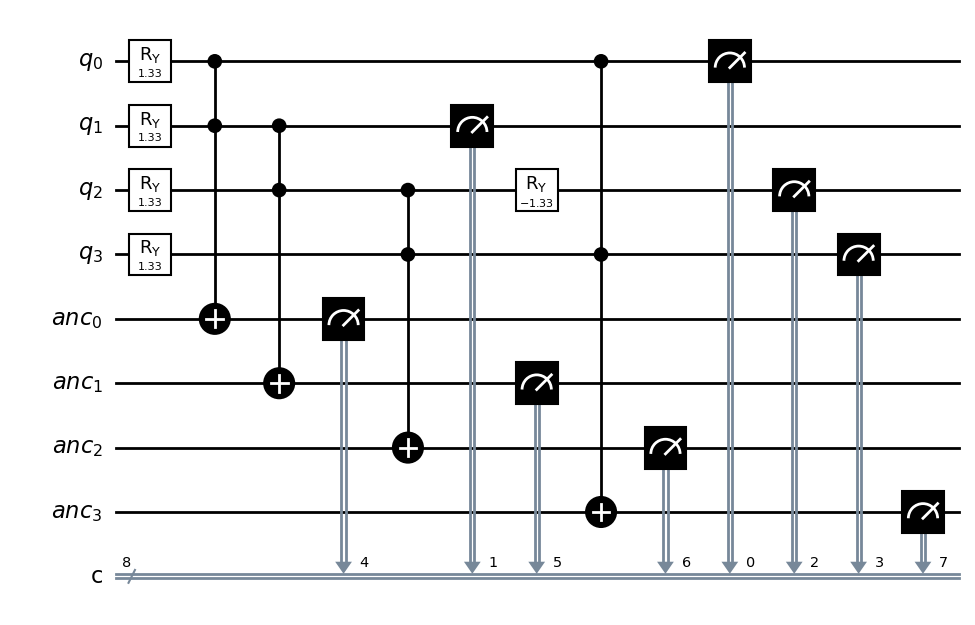

In [25]:
n = 4
num_pairs = 4
qc23p = QuantumCircuit(q,c,anc)
qc23p.ry(theta, q)
qc23p.mct([q[0],q[1]], anc[0], mode='noancilla')
qc23p.mct([q[1],q[2]], anc[1], mode='noancilla')
qc23p.mct([q[2],q[3]], anc[2], mode='noancilla')
qc23p.mct([q[0],q[3]], anc[3], mode='noancilla')
qc23p.ry(-theta, q[2])
qc23p.measure(q[0:n], c[0:n])
qc23p.measure(anc, c[n:n+num_pairs])
qc23p.draw(output='mpl', style='bw')

### 2.3.2. Raw data

In [29]:
job23 = execute(qc23p, backend=backend, shots=num_shots)
result23 = job23.result()
count23 = result23.get_counts()

d = 0
for n in range (num_pairs):
    for k, v in list(count23.items()):
        i=0
        for p in range(1):
            if len(k) > 0 and k[0] == '1':
                d = d + v
                del count23[k]
                break
            i+=1

    for k,v in list(count23.items()):
        count23[k[1:]]=count23.pop(k)
        
count23 = {state[::-1]: population for state, population in count23.items()}

### 2.3.3. Final result
- In this condition, three states of interest are $\left|0110\right\rangle, \left|0011\right\rangle$, and $\left|0111\right\rangle$.

In [31]:
df4 = pd.DataFrame(list(count23.items()), columns=["States", "Counts"])
df4.to_excel("cond23sim_data.xlsx", index=False)
simulation23 = pd.read_excel("cond23sim_data.xlsx", dtype={"States": str})
count23 = dict(zip(simulation23["States"], simulation23["Counts"]))

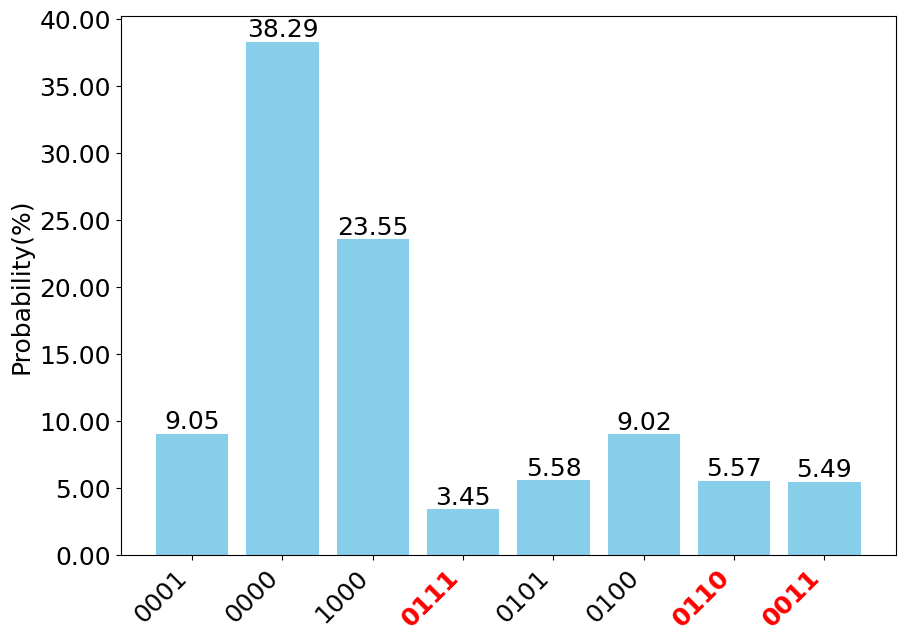

In [32]:
total_count = sum(count23.values())

probabilities = {state: count / total_count for state, count in count23.items()}

states = list(probabilities.keys())  
prob_values = list(probabilities.values())

plt.figure(figsize=(10, 7))
bars = plt.bar(states, prob_values, color='skyblue')

for bar, prob in zip(bars, prob_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{prob * 100:.2f}', ha='center', va='bottom', fontsize=18)

highlight_states = {'0110', '0011', '0111'}  
tick_labels = plt.gca().get_xticklabels()  
tick_labels_text = plt.gca().get_xticklabels() 
for label, state in zip(tick_labels_text, states):  
    if state in highlight_states:
        label.set_color('red')  
        label.set_fontweight('bold') 

def to_percent(y, _):
    return f'{y * 100:.2f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Probability(%)", fontsize=18)

plt.show()

## 2.4. Changing the fourth qubit's basis
### 2.4.1. Quantum circuit

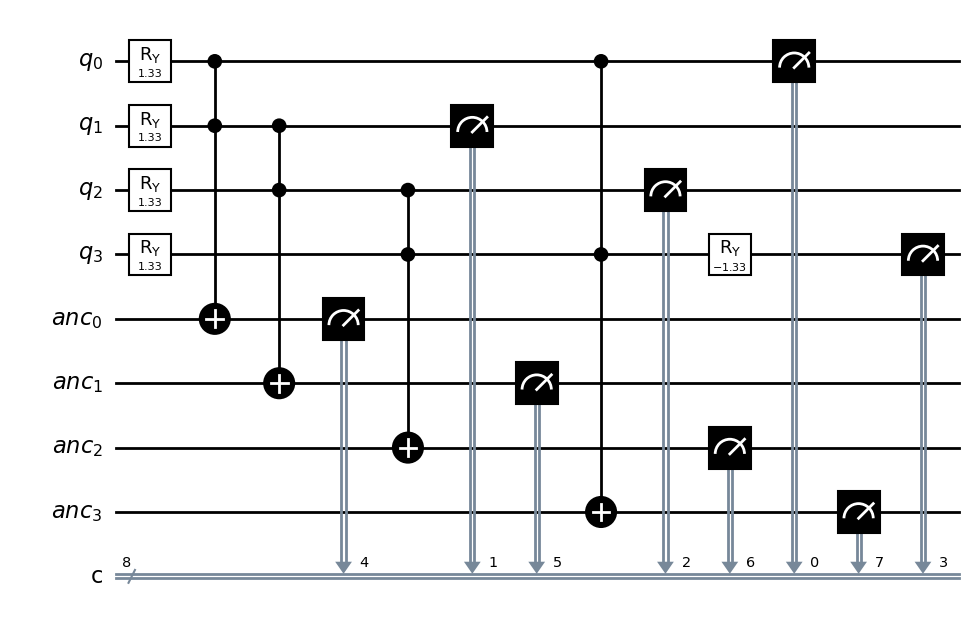

In [31]:
n = 4
num_pairs = 4
qc24p = QuantumCircuit(q,c,anc)
qc24p.ry(theta, q)
qc24p.mct([q[0],q[1]], anc[0], mode='noancilla')
qc24p.mct([q[1],q[2]], anc[1], mode='noancilla')
qc24p.mct([q[2],q[3]], anc[2], mode='noancilla')
qc24p.mct([q[0],q[3]], anc[3], mode='noancilla')
qc24p.ry(-theta, q[3])
qc24p.measure(q[0:n], c[0:n])
qc24p.measure(anc, c[n:n+num_pairs])
qc24p.draw(output='mpl', style='bw')

### 2.4.2. Raw data

In [33]:
job24 = execute(qc24p, backend=backend, shots=num_shots)
result24 = job24.result()
count24 = result24.get_counts()

d = 0
for n in range (num_pairs):
    for k, v in list(count24.items()):
        i=0
        for p in range(1):
            if len(k) > 0 and k[0] == '1':
                d = d + v
                del count24[k]
                break
            i+=1

    for k,v in list(count24.items()):
        count24[k[1:]]=count24.pop(k)
        
count24 = {state[::-1]: population for state, population in count24.items()}

### 2.4.3. Final result
- In this condition, three states of interest are $\left|0011\right\rangle, \left|1011\right\rangle$, and $\left|1001\right\rangle$.

In [34]:
df5 = pd.DataFrame(list(count24.items()), columns=["States", "Counts"])
df5.to_excel("cond24sim_data.xlsx", index=False)
simulation24 = pd.read_excel("cond24sim_data.xlsx", dtype={"States": str})
count24 = dict(zip(simulation24["States"], simulation24["Counts"]))

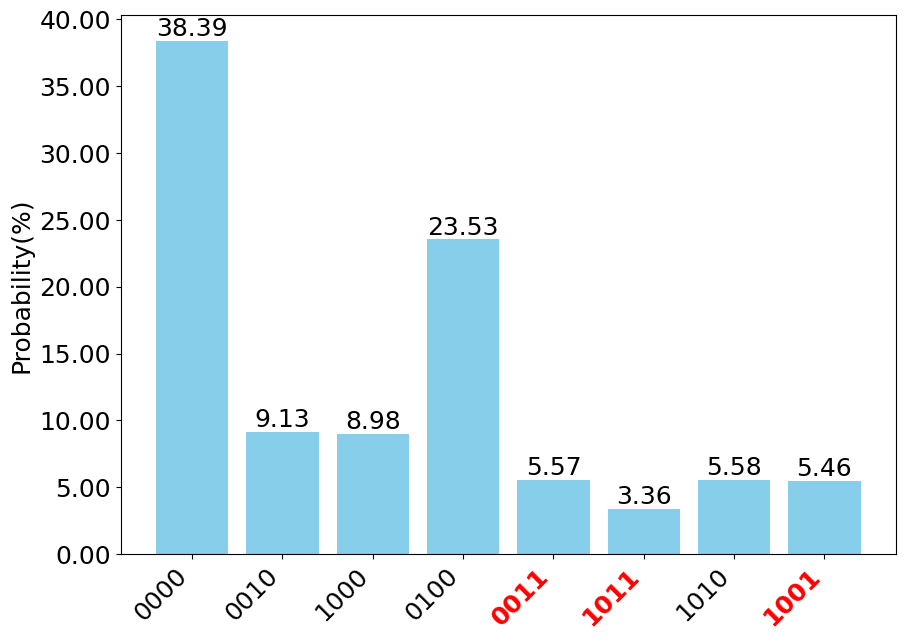

In [35]:
total_count = sum(count24.values())

probabilities = {state: count / total_count for state, count in count24.items()}

states = list(probabilities.keys())  
prob_values = list(probabilities.values())

plt.figure(figsize=(10, 7))
bars = plt.bar(states, prob_values, color='skyblue')

for bar, prob in zip(bars, prob_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
              f'{prob * 100:.2f}', ha='center', va='bottom', fontsize=18)

highlight_states = {'1001', '0011', '1011'}  
tick_labels = plt.gca().get_xticklabels()  
tick_labels_text = plt.gca().get_xticklabels() 
for label, state in zip(tick_labels_text, states):  
    if state in highlight_states:
        label.set_color('red')  
        label.set_fontweight('bold') 

def to_percent(y, _):
    return f'{y * 100:.2f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Probability(%)", fontsize=18)

plt.show()

# 3. Third set of conditions
- In this set, $R_y(-\theta)$ is apllied to all four qubit to transform all of them to {c, d} basis.
- States of interest in this set are also highlighted in red color.
- From the correlation between qubits pointed out from the second set, these states can cause all vanished states in the first set to have nonzero measurement probabilities, which creates the Hardy's paradox.
## 3.1. Quantum circuit

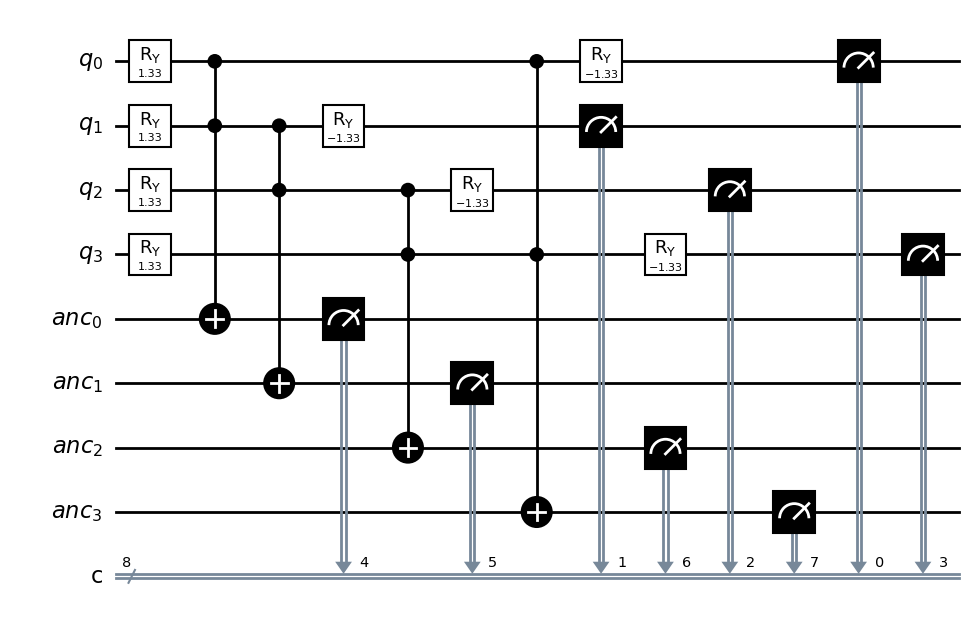

In [37]:
# 3rd condition
n = 4
num_pairs = 4
qc3p = QuantumCircuit(q,c,anc)
qc3p.ry(theta, q)
qc3p.mct([q[0],q[1]], anc[0], mode='noancilla')
qc3p.mct([q[1],q[2]], anc[1], mode='noancilla')
qc3p.mct([q[2],q[3]], anc[2], mode='noancilla')
qc3p.mct([q[0],q[3]], anc[3], mode='noancilla')
qc3p.ry(-theta, q)
qc3p.measure(q[0:n], c[0:n])
qc3p.measure(anc, c[n:n+num_pairs])
qc3p.draw(output='mpl', style='bw')

## 3.2. Raw data

In [38]:
job3 = execute(qc3p, backend=backend, shots=num_shots)
result3 = job3.result()
count3 = result3.get_counts()

d = 0
for n in range (num_pairs):
    for k, v in list(count3.items()):
        i=0
        for p in range(1):
            if len(k) > 0 and k[0] == '1':
                d = d + v
                del count3[k]
                break
            i+=1

    for k,v in list(count3.items()):
        count3[k[1:]]=count3.pop(k)
        
count3 = {state[::-1]: population for state, population in count3.items()}

## 3.3. Final result

In [39]:
df6 = pd.DataFrame(list(count3.items()), columns=["States", "Counts"])
df6.to_excel("cond3sim_data.xlsx", index=False)
simulation3 = pd.read_excel("cond3sim_data.xlsx", dtype={"States": str})
count3 = dict(zip(simulation3["States"], simulation3["Counts"]))

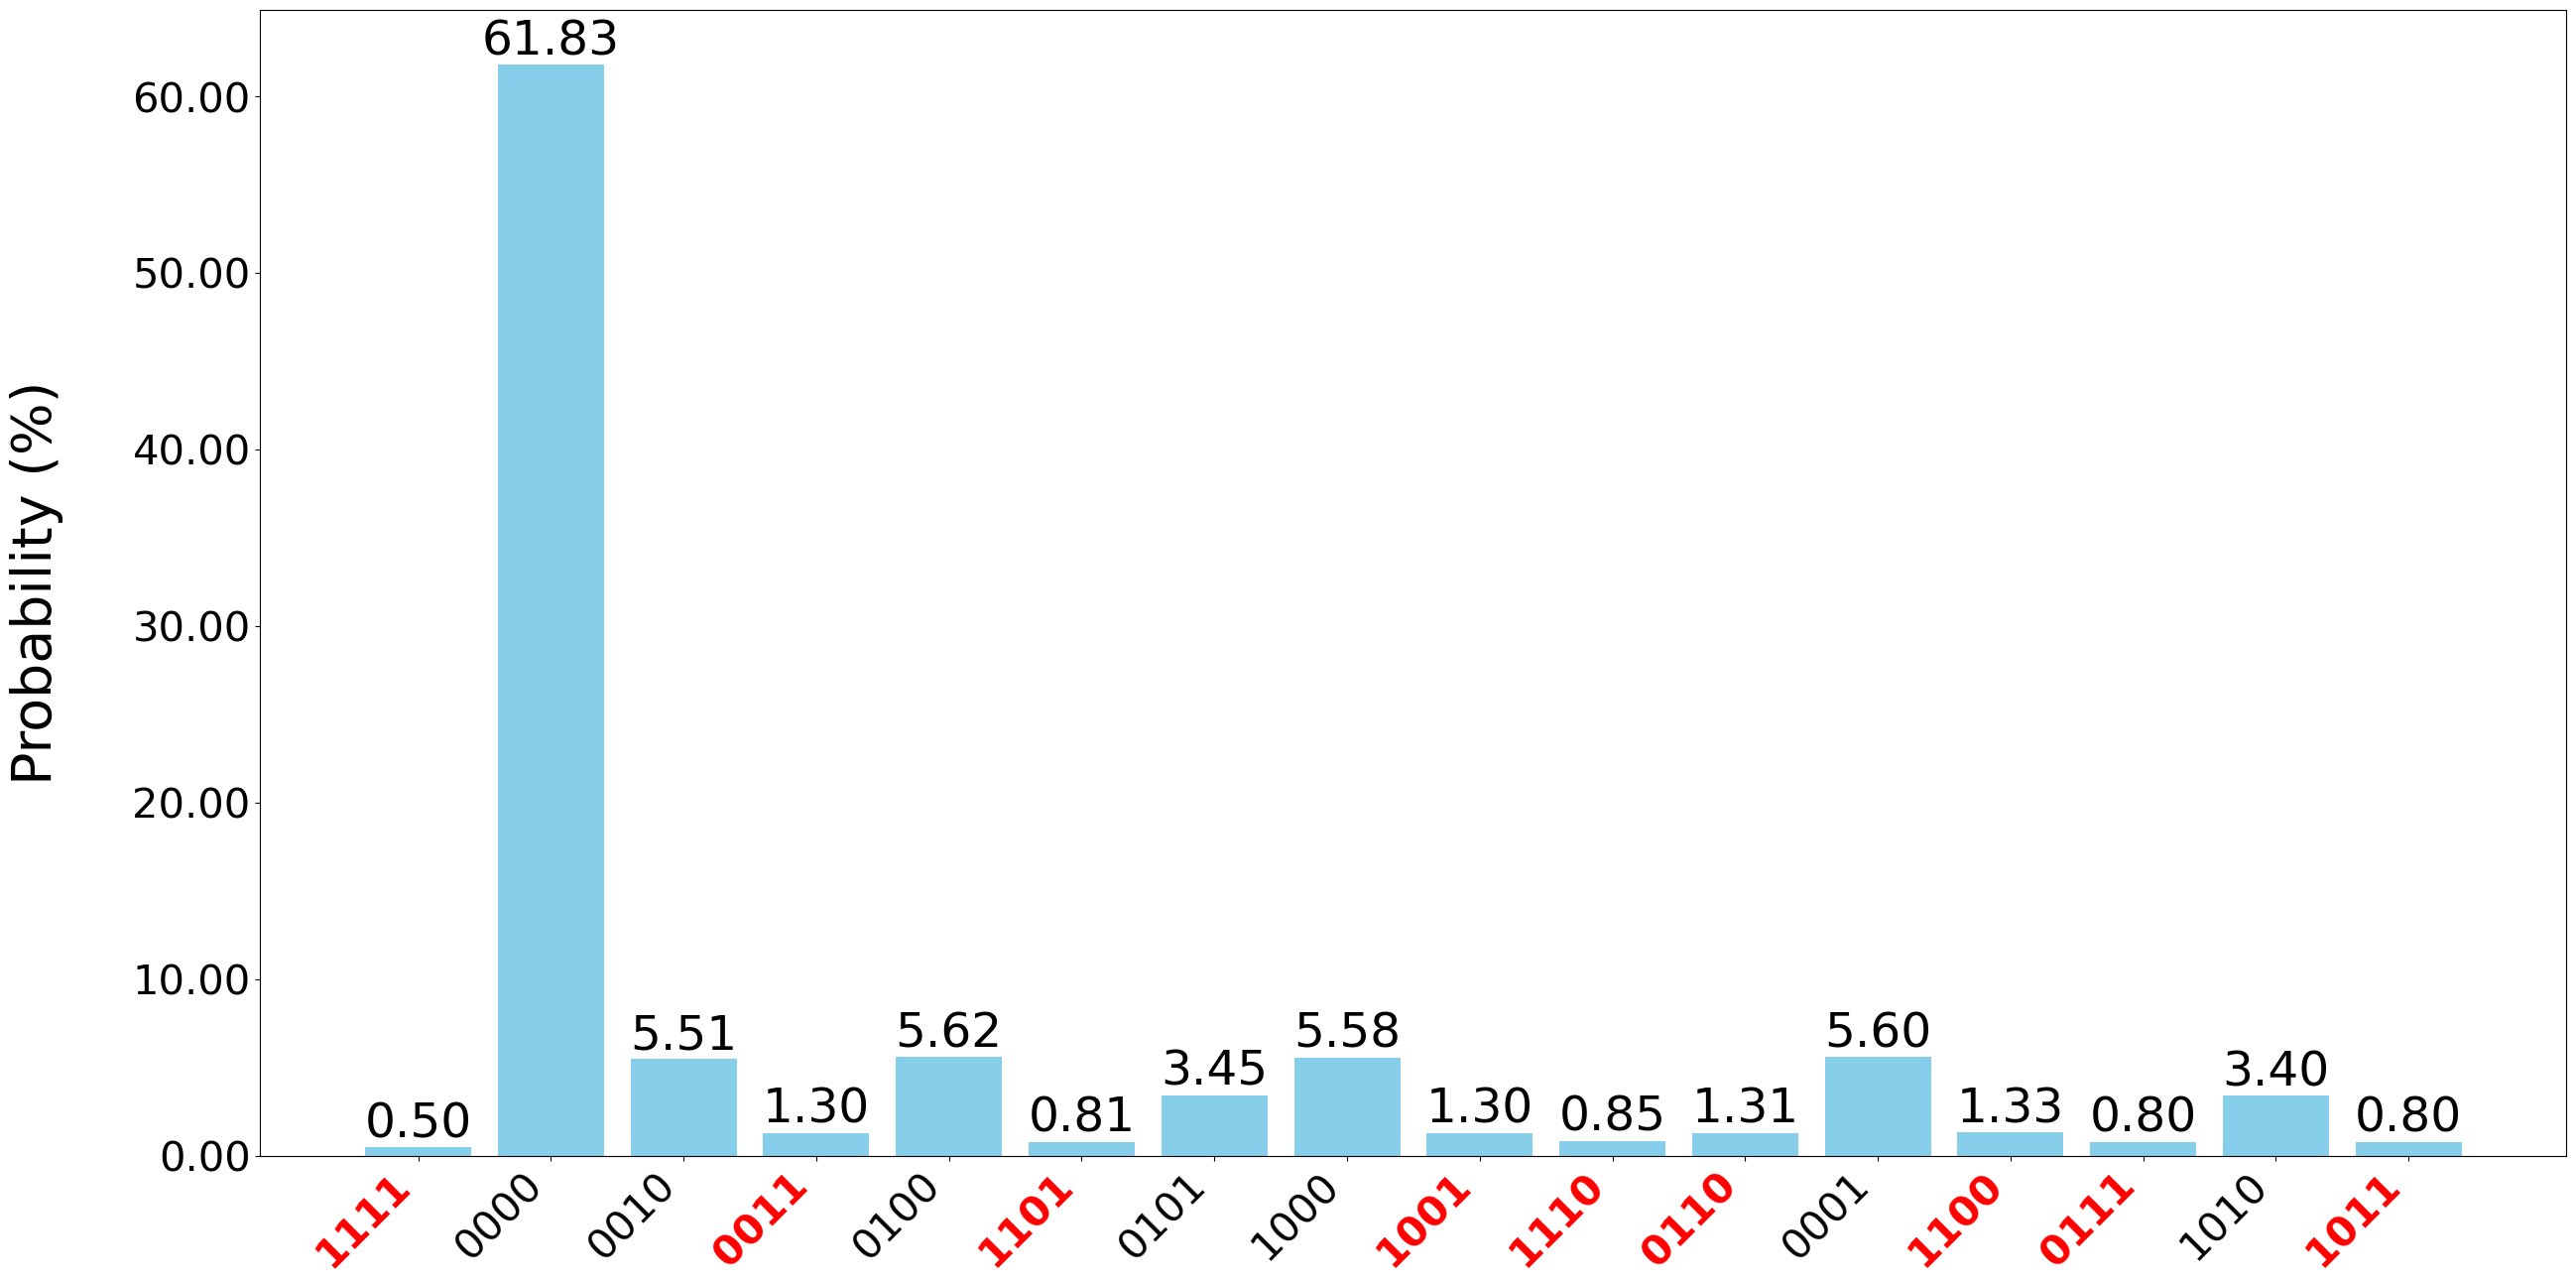

In [40]:
total_count = sum(count3.values())

probabilities = {state: count / total_count for state, count in count3.items()}

states = list(probabilities.keys())  
prob_values = list(probabilities.values())

plt.figure(figsize=(30,15))
bars = plt.bar(states, prob_values, color='skyblue', width=0.8)

for bar, prob in zip(bars, prob_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{prob * 100:.2f}', ha='center', va='bottom', fontsize=35)

highlight_states = {'1001', '0011', '1011', '1111', '1101', '1100', '0110', '1110', '0111'}  
tick_labels = plt.gca().get_xticklabels()  
tick_labels_text = plt.gca().get_xticklabels() 
for label, state in zip(tick_labels_text, states):  
    if state in highlight_states:
        label.set_color('red')  
        label.set_fontweight('bold') 

def to_percent(y, _):
    return f'{y * 100:.2f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Probability (%)", fontsize=40, labelpad=50)

plt.show()

- The $P_{success}$ can be calculated as the sum of these nine states' measurement probabilities 

In [41]:
p = 0
sum_values = sum(count3.values())
p = count3.get('1100', 0) / sum_values + count3.get('0011', 0) / sum_values + count3.get('0110', 0) / sum_values + count3.get('1001', 0) / sum_values
p += sum(value / sum_values for key, value in count3.items() if key.count('1') > 2)
p

0.09008320463928898